# Neural Networks and GLoVe modeling with PCA and cleaned dataframe 

In [1]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
import pandas as pd
import numpy as np
np.random.seed(0)
from nltk import word_tokenize
from gensim.models import word2vec

Using TensorFlow backend.


In [49]:
import talos as ta
from keras.layers import Dropout

In [47]:
from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer

In [214]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns

In [234]:
import matplotlib.pyplot as plt


In [46]:
%matplotlib inline

In [192]:
df = pd.read_csv('updated_merged_data.csv')

In [193]:
df.head()

,Unnamed: 0,retweet_from,tweet_length,encoded_sentiment,polarity,tweet,pc_1,pc_2,pc_3,pc_4,...,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,signal_y
0,0,171,105,1,0.366667,assuming acceleration of to but in a comfortab...,-0.031750,-0.028850,-0.030290,-0.018736,...,0.017885,0.045822,-0.006862,-0.012954,-0.005468,-0.100572,-0.029374,0.041363,0.035932,stay
1,1,77,113,1,0.200000,is capable of transporting satellite to orbit ...,-0.059331,-0.099826,-0.154772,-0.040355,...,-0.011667,0.003882,0.018002,-0.019813,-0.035809,-0.034079,-0.014687,-0.008986,-0.019845,stay
2,2,171,6,0,0.000000,yup,-0.002330,0.033983,0.069531,-0.014177,...,0.015722,-0.025726,0.065735,0.041686,-0.021751,-0.014138,-0.037047,-0.050031,-0.084722,stay
3,3,171,7,0,0.000000,part,-0.005050,0.024117,0.043362,-0.001804,...,-0.009052,-0.008601,0.001285,-0.007619,-0.005289,-0.025700,-0.008989,-0.011967,-0.004665,stay
4,4,171,96,1,0.650000,fly to most place on earth in under min and an...,-0.031167,-0.027725,-0.012331,-0.039909,...,0.020042,0.030526,-0.039462,0.088186,-0.012277,0.033849,0.040576,0.051975,-0.031236,stay


In [194]:
df.drop(columns = ['Unnamed: 0'], inplace= True)

In [195]:
# set the tweet column to a string to account of data type errors
df.tweet = df.tweet.astype(str)

## Check the class balance of our target classes

In [196]:
target = df.signal_y

In [197]:
target.head()

0    stay
1    stay
2    stay
3    stay
4    stay
Name: signal_y, dtype: object

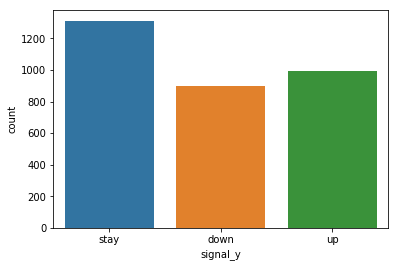

In [215]:
sns.countplot(df['signal_y'])

In [198]:
df["signal_y"].value_counts()

stay    1311
up       993
down     900
Name: signal_y, dtype: int64

In [199]:
df["signal_y"].value_counts(normalize=True)

stay    0.409176
up      0.309925
down    0.280899
Name: signal_y, dtype: float64

## Set the target to an array of dummies for our three classes (stay, up, down)


We use this y (the target) for all of our models

In [200]:
y = pd.get_dummies(target).values

In [201]:
print(type(y))
y[:4]

<type 'numpy.ndarray'>


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

# Exploratory Data Analysis 

In [220]:
df_graph = df[['tweet']]

In [221]:
df_graph['tweet_length'] = df['tweet'].apply(len)

In [227]:
df_graph['encoded_sentiment'] = df['encoded_sentiment']

In [245]:
df_graph['target'] = target

In [246]:
df_graph.head()

,tweet,tweet_length,encoded_sentiment,target
0,assuming acceleration of to but in a comfortab...,83,1,stay
1,is capable of transporting satellite to orbit ...,94,1,stay
2,yup,3,0,stay
3,part,4,0,stay
4,fly to most place on earth in under min and an...,85,1,stay


In [225]:
df_graph['tweet_length'].describe()

count    3205.000000
mean       57.876443
std        33.344703
min         1.000000
25%        30.000000
50%        59.000000
75%        85.000000
max       136.000000
Name: tweet_length, dtype: float64

The mean tweet length is 57 characters, and the minimun is 1.

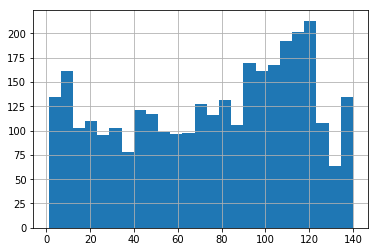

In [248]:
df['tweet_length'].hist(bins = 25)

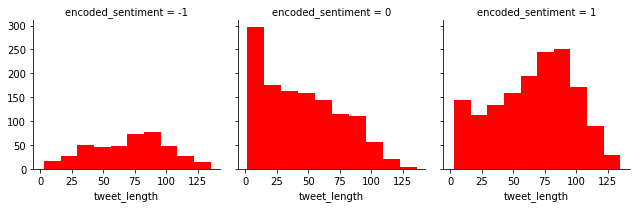

In [258]:
sentiment_graph = sns.FacetGrid(df_graph,col='encoded_sentiment')
sentiment_graph.map(plt.hist,'tweet_length', color='r')



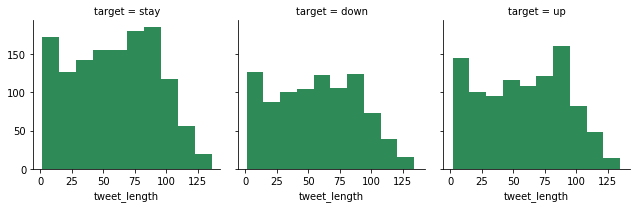

In [257]:
target_graph = sns.FacetGrid(df_graph,col='target')
target_graph.map(plt.hist,'tweet_length', color='seagreen')

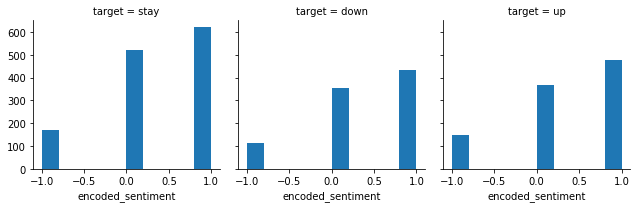

In [249]:
target_sentiment_graph = sns.FacetGrid(df_graph,col='target')
target_sentiment_graph.map(plt.hist,'encoded_sentiment')

# ANN Model for non tweet features

Make the dataframe for not tweet features, which include the tf-idf of the tweets.

In [202]:
df_no_tweet = df.drop(['signal_y', 'tweet'], axis=1)

In [203]:
df_no_tweet.head()

,retweet_from,tweet_length,encoded_sentiment,polarity,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,...,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38
0,171,105,1,0.366667,-0.031750,-0.028850,-0.030290,-0.018736,-0.060675,0.057798,...,-0.002729,0.017885,0.045822,-0.006862,-0.012954,-0.005468,-0.100572,-0.029374,0.041363,0.035932
1,77,113,1,0.200000,-0.059331,-0.099826,-0.154772,-0.040355,0.072285,0.209163,...,-0.059361,-0.011667,0.003882,0.018002,-0.019813,-0.035809,-0.034079,-0.014687,-0.008986,-0.019845
2,171,6,0,0.000000,-0.002330,0.033983,0.069531,-0.014177,-0.037774,-0.071279,...,0.087971,0.015722,-0.025726,0.065735,0.041686,-0.021751,-0.014138,-0.037047,-0.050031,-0.084722
3,171,7,0,0.000000,-0.005050,0.024117,0.043362,-0.001804,-0.016279,-0.052016,...,0.015861,-0.009052,-0.008601,0.001285,-0.007619,-0.005289,-0.025700,-0.008989,-0.011967,-0.004665
4,171,96,1,0.650000,-0.031167,-0.027725,-0.012331,-0.039909,-0.070462,0.019591,...,-0.081234,0.020042,0.030526,-0.039462,0.088186,-0.012277,0.033849,0.040576,0.051975,-0.031236


In [204]:
# these are the features for the no_tweet ANN model
X = df_no_tweet.as_matrix()

In [205]:
X[:2]

array([[ 1.71000000e+02,  1.05000000e+02,  1.00000000e+00,
         3.66666667e-01, -3.17503779e-02, -2.88503208e-02,
        -3.02899383e-02, -1.87361455e-02, -6.06745282e-02,
         5.77981532e-02, -1.24514649e-01,  1.16679040e-01,
         5.94730409e-02, -2.91580810e-02, -4.82227257e-02,
         7.24178428e-02,  3.90785157e-02,  2.93682030e-02,
        -5.01187584e-02,  1.81687862e-02,  1.42445412e-02,
        -3.82909349e-02,  9.11399155e-03, -3.36043675e-02,
         3.00319803e-03,  1.42111843e-02,  1.02493801e-02,
         1.01547097e-02,  3.73028256e-02, -1.27392087e-02,
         3.30800335e-03, -4.88425818e-02, -2.72917718e-03,
         1.78852054e-02,  4.58221637e-02, -6.86176435e-03,
        -1.29544357e-02, -5.46828939e-03, -1.00572163e-01,
        -2.93740249e-02,  4.13625539e-02,  3.59321462e-02],
       [ 7.70000000e+01,  1.13000000e+02,  1.00000000e+00,
         2.00000000e-01, -5.93306206e-02, -9.98259555e-02,
        -1.54772144e-01, -4.03554083e-02,  7.22851718e-

In [206]:
# this is check the target for the Neural Network
print(type(y))

<type 'numpy.ndarray'>


In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [283]:
classifier = Sequential()
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
classifier.add(Dense(units = 3, kernel_initializer='uniform', activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
c = classifier.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_split=0.1)

Train on 2307 samples, validate on 257 samples
Epoch 1/100
2307/2307 [==============================] - 3s 1ms/step - loss: 1.0881 - acc: 0.4083 - val_loss: 1.0820 - val_acc: 0.4163
Epoch 2/100
2307/2307 [==============================] - 1s 314us/step - loss: 1.0864 - acc: 0.4088 - val_loss: 1.0818 - val_acc: 0.4163
Epoch 3/100
2307/2307 [==============================] - 1s 314us/step - loss: 1.0858 - acc: 0.4088 - val_loss: 1.0810 - val_acc: 0.4163
Epoch 4/100
2307/2307 [==============================] - 1s 309us/step - loss: 1.0859 - acc: 0.4088 - val_loss: 1.0827 - val_acc: 0.4163
Epoch 5/100
2307/2307 [==============================] - 1s 322us/step - loss: 1.0858 - acc: 0.4092 - val_loss: 1.0840 - val_acc: 0.4163
Epoch 6/100
2307/2307 [==============================] - 1s 309us/step - loss: 1.0849 - acc: 0.4088 - val_loss: 1.0840 - val_acc: 0.4163
Epoch 7/100
2307/2307 [==============================] - 1s 315us/step - loss: 1.0848 - acc: 0.4088 - val_loss: 1.0826 - val_acc: 0.4

2307/2307 [==============================] - 1s 345us/step - loss: 1.0801 - acc: 0.4088 - val_loss: 1.0834 - val_acc: 0.4163
Epoch 61/100
2307/2307 [==============================] - 1s 317us/step - loss: 1.0804 - acc: 0.4096 - val_loss: 1.0842 - val_acc: 0.4163
Epoch 62/100
2307/2307 [==============================] - 1s 304us/step - loss: 1.0806 - acc: 0.4096 - val_loss: 1.0829 - val_acc: 0.4202
Epoch 63/100
2307/2307 [==============================] - 1s 310us/step - loss: 1.0788 - acc: 0.4153 - val_loss: 1.0851 - val_acc: 0.4008
Epoch 64/100
2307/2307 [==============================] - 1s 327us/step - loss: 1.0789 - acc: 0.4166 - val_loss: 1.0840 - val_acc: 0.4086
Epoch 65/100
2307/2307 [==============================] - 1s 315us/step - loss: 1.0799 - acc: 0.4101 - val_loss: 1.0832 - val_acc: 0.4125
Epoch 66/100
2307/2307 [==============================] - 1s 290us/step - loss: 1.0786 - acc: 0.4170 - val_loss: 1.0838 - val_acc: 0.4125
Epoch 67/100
2307/2307 [=======================

In [284]:
score_no_tweet, acc_no_tweet = classifier.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score for no tweet model: %.2f" % (score_no_tweet))
print("acc for no tweet model: %.2f" % (acc_no_tweet))

score for no tweet model: 1.09
acc for no tweet model: 0.41


In [212]:
y_pred_test = classifier.predict(X_test, verbose = 2, batch_size = 32)


The neural network for the non-tweet data has a 66% accuracy rate.

In [265]:
classifier.history.params['metrics'][1].values()

AttributeError: 'str' object has no attribute 'values'

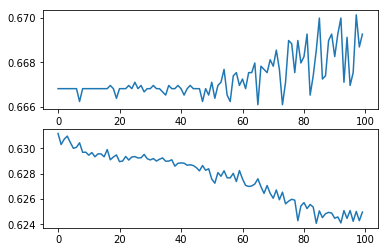

In [273]:
plt.figure()
plt.subplot(211)
plt.plot(c.history['acc'])
plt.subplot(212)
plt.plot(c.history['loss'])

['acc', 'loss', 'val_acc', 'val_loss']


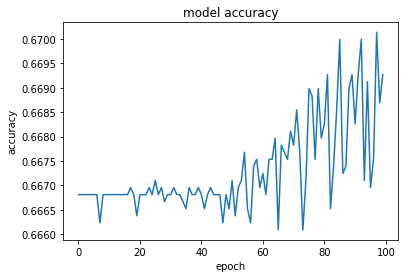

In [281]:
print(c.history.keys()) 
plt.plot(c.history['acc']) 

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

['acc', 'loss', 'val_acc', 'val_loss']


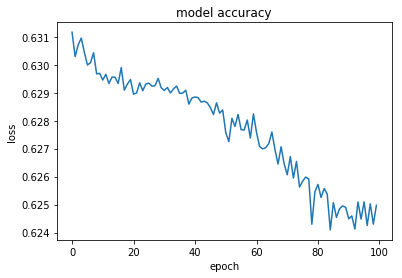

In [280]:
print(c.history.keys()) 
plt.plot(c.history['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# ANN Model with tweets included

First, tokenize the tweets to feed into the model.

In [35]:
tokenizer = text.Tokenizer(num_words=15000)
tokenizer.fit_on_texts(list(df.tweet))
list_tokenized_tweets = tokenizer.texts_to_sequences(df.tweet)
X_t = sequence.pad_sequences(list_tokenized_tweets) 

In [36]:
print(type(X_t))
print(X_t.shape)
X_t[:3]

<type 'numpy.ndarray'>
(3205, 28)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1328,  711,    4,    2,   16,    6,    3, 1633, 1329,
          12,  351,   36,    3, 2220,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    5,
         712,    4, 1634,  156,    2,  151,  394,    9,  461,    2,    1,
           9,  127,    2,    1,  276,   47],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  505]], dtype=int32)

In [27]:
print(type(X))
print(X.shape)
X[:3]

<type 'numpy.ndarray'>
(3205, 42)


array([[ 1.71000000e+02,  1.05000000e+02,  1.00000000e+00,
         3.66666667e-01, -3.17503779e-02, -2.88503208e-02,
        -3.02899383e-02, -1.87361455e-02, -6.06745282e-02,
         5.77981532e-02, -1.24514649e-01,  1.16679040e-01,
         5.94730409e-02, -2.91580810e-02, -4.82227257e-02,
         7.24178428e-02,  3.90785157e-02,  2.93682030e-02,
        -5.01187584e-02,  1.81687862e-02,  1.42445412e-02,
        -3.82909349e-02,  9.11399155e-03, -3.36043675e-02,
         3.00319803e-03,  1.42111843e-02,  1.02493801e-02,
         1.01547097e-02,  3.73028256e-02, -1.27392087e-02,
         3.30800335e-03, -4.88425818e-02, -2.72917718e-03,
         1.78852054e-02,  4.58221637e-02, -6.86176435e-03,
        -1.29544357e-02, -5.46828939e-03, -1.00572163e-01,
        -2.93740249e-02,  4.13625539e-02,  3.59321462e-02],
       [ 7.70000000e+01,  1.13000000e+02,  1.00000000e+00,
         2.00000000e-01, -5.93306206e-02, -9.98259555e-02,
        -1.54772144e-01, -4.03554083e-02,  7.22851718e-

In [31]:
X_try = np.append(X_t, X, axis=1)

In [32]:
X_try.shape

(3205, 70)

In [37]:
# use X_try because it combines tweets vectors and pca vectors
X_try[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.32800000e+03,  7.11000000e+02,  4.00000000e+00,
        2.00000000e+00,  1.60000000e+01,  6.00000000e+00,  3.00000000e+00,
        1.63300000e+03,  1.32900000e+03,  1.20000000e+01,  3.51000000e+02,
        3.60000000e+01,  3.00000000e+00,  2.22000000e+03,  2.00000000e+00,
        1.71000000e+02,  1.05000000e+02,  1.00000000e+00,  3.66666667e-01,
       -3.17503779e-02, -2.88503208e-02, -3.02899383e-02, -1.87361455e-02,
       -6.06745282e-02,  5.77981532e-02, -1.24514649e-01,  1.16679040e-01,
        5.94730409e-02, -2.91580810e-02, -4.82227257e-02,  7.24178428e-02,
        3.90785157e-02,  2.93682030e-02, -5.01187584e-02,  1.81687862e-02,
        1.42445412e-02, -3.82909349e-02,  9.11399155e-03, -3.36043675e-02,
        3.00319803e-03,  

In [38]:
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X_try, y, test_size = 0.2, random_state = 0)



In [58]:
ann.history

{'acc': [0.662187561799708,
  0.664065903097094,
  0.6681115638398484,
  0.6692674673890261,
  0.6691229788317637,
  0.6720127371879796,
  0.6741800526287011,
  0.6730241489503411,
  0.6801040531186557,
  0.6848721507053434,
  0.6880508829465303,
  0.6886288340752085,
  0.6915185911396028,
  0.6907961532622123,
  0.6948418118088702,
  0.6916630800844117,
  0.694119372691331,
  0.6965756628696258,
  0.7007658081649959,
  0.7071232722598234,
  0.7029331272228176,
  0.7032221017536995,
  0.7081346909980212,
  0.7042335153246112,
  0.7100130297117643,
  0.7100130275156676,
  0.7084236634619886,
  0.714492148504559,
  0.7170929284544285,
  0.7129027840633334,
  0.7124693209751891,
  0.7204161504155172,
  0.7155035653050245,
  0.7160815134625131,
  0.7147811263941768,
  0.7191157619261772,
  0.7221500047058268,
  0.7195492201053998,
  0.7238838577043147,
  0.7257621968056043,
  0.7266291265989931,
  0.7251842452893796,
  0.7240283447630642,
  0.7290854183791466,
  0.7274960503208209,
  0.727

In [39]:
classifier = Sequential()
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
classifier.add(Dense(units = 3, kernel_initializer='uniform', activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann = classifier.fit(X_train_tweet, y_train_tweet, batch_size = 10, epochs = 100, validation_split=0.1)

Train on 2307 samples, validate on 257 samples
Epoch 1/100
2307/2307 [==============================] - 2s 656us/step - loss: 0.6382 - acc: 0.6622 - val_loss: 0.6338 - val_acc: 0.6654
Epoch 2/100
2307/2307 [==============================] - 1s 329us/step - loss: 0.6308 - acc: 0.6641 - val_loss: 0.6368 - val_acc: 0.6602
Epoch 3/100
2307/2307 [==============================] - 1s 332us/step - loss: 0.6268 - acc: 0.6681 - val_loss: 0.6314 - val_acc: 0.6641
Epoch 4/100
2307/2307 [==============================] - 1s 338us/step - loss: 0.6245 - acc: 0.6693 - val_loss: 0.6422 - val_acc: 0.6641
Epoch 5/100
2307/2307 [==============================] - 1s 334us/step - loss: 0.6233 - acc: 0.6691 - val_loss: 0.6360 - val_acc: 0.6589
Epoch 6/100
2307/2307 [==============================] - 1s 341us/step - loss: 0.6210 - acc: 0.6720 - val_loss: 0.6318 - val_acc: 0.6641
Epoch 7/100
2307/2307 [==============================] - 1s 361us/step - loss: 0.6182 - acc: 0.6742 - val_loss: 0.6481 - val_acc: 0

2307/2307 [==============================] - 1s 286us/step - loss: 0.5271 - acc: 0.7301 - val_loss: 0.8840 - val_acc: 0.6265
Epoch 61/100
2307/2307 [==============================] - 1s 286us/step - loss: 0.5279 - acc: 0.7288 - val_loss: 0.8735 - val_acc: 0.6291
Epoch 62/100
2307/2307 [==============================] - 1s 286us/step - loss: 0.5211 - acc: 0.7344 - val_loss: 0.9241 - val_acc: 0.6174
Epoch 63/100
2307/2307 [==============================] - 1s 298us/step - loss: 0.5366 - acc: 0.7297 - val_loss: 0.9131 - val_acc: 0.6122
Epoch 64/100
2307/2307 [==============================] - 1s 300us/step - loss: 0.5291 - acc: 0.7307 - val_loss: 0.8625 - val_acc: 0.6407
Epoch 65/100
2307/2307 [==============================] - 1s 292us/step - loss: 0.5233 - acc: 0.7344 - val_loss: 0.8101 - val_acc: 0.6433
Epoch 66/100
2307/2307 [==============================] - 1s 289us/step - loss: 0.5311 - acc: 0.7315 - val_loss: 0.8537 - val_acc: 0.6420
Epoch 67/100
2307/2307 [=======================

In [43]:
score_tweet, acc_tweet = classifier.evaluate(X_test_tweet, y_test_tweet, verbose = 2, batch_size = 32)
print("score: %.2f" % (score_tweet))
print("acc: %.2f" % (acc_tweet))

score: 0.99
acc: 0.62


The neural network for tweets and pca has a 62% accuracy rate.

# Tuning with talos

In [123]:

# def tweet_model(x_train, y_trainz, x_val, y_val, params):
    
#     model = Sequential()                            
#     model.add(Dense(params['first_neuron'],
#                     input_dim=x_train.shape[1],
#                     activation='relu'))
    
#     model.add(Dropout(params['dropout']))
#     model.add(Dense(y_trainz.shape[1],
#                     activation=params['last_activation']))

#     model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
#                   loss=params['loss'],
#                   metrics=['acc'])

#     out = model.fit(x_train, y_trainz,
#                     batch_size=params['batch_size'],
#                     epochs=params['epochs'],
#                     verbose=0,
#                     validation_split = 0.1,
#                     callbacks=early_stopper(params['epochs'], mode='strict'))
# #     model.fit(x_train, y_train,
# #                 batch_size=params['batch_size'],
# #                 epochs=params['epochs'],
# #                 verbose=0,
# #                 validation_data=[x_val, y_val],
# #                 callbacks=early_stopper(params['epochs'], mode='strict'))

# #     out = model.history
#     return out, model

In [183]:
# first we have to make sure to input data and params into the function
def tweet_model(x_train, y_train, x_val, y_val, params):
    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(15, input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer='uniform'))
    
    model.add(Dropout(params['dropout']))
    
    # trying to add a layer
    model.add(Dense(15, input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer='uniform'))
    
    model.add(Dropout(params['dropout']))
    
    # if we want to also test for number of layers and shapes, that's possible
#     hidden_layers(model, params, 1)
   
    # then we finish again with completely standard Keras way
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    model.compile(loss='categorical_crossentropy',
                  # here we add a regulizer normalization function from Talos
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=['acc'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    # finally we have to make sure that history object and model are returned
    return history, model

In [184]:
# classifier = Sequential()
# classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
# classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
# classifier.add(Dense(units = 3, kernel_initializer='uniform', activation = 'softmax'))
# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# classifier.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_split=0.1)

In [185]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

# p = {'lr': (0.1, 10, 10),
#      'first_neuron':[4, 8, 16, 32, 64, 128],
#      'batch_size': [2, 3, 4],
#      'epochs': [200],
#      'dropout': (0, 0.40, 10),
#      'optimizer': [Adam, Nadam],
#      'loss': [categorical_crossentropy, logcosh],
#      'last_activation': [softmax],
#      'weight_regulizer':[None]}

p = {'lr': (0, 0.1, 0.2),
     'first_neuron':[4, 8, 16, 32, 64],
     'hidden_layers':[0, 1, 2],
     'batch_size': (2, 20, 40),
     'epochs': [100],
     'dropout': (0, 0.5, 0.9),
     'weight_regulizer':[None],
     'emb_output_dims': [None],
#      'shape':['brick','long_funnel'],
     'optimizer': [Adam],
#      'losses': [logcosh, binary_crossentropy],
     'activation':['relu', 'tanh'],
     'last_activation': [softmax]}

In [186]:
h = ta.Scan(X_try, y, params=p,
            model=tweet_model,
            dataset_name='tweet',
            experiment_no='1',
           grid_downsample=.01)
































  0%|          | 0/5 [00:00<?, ?it/s]






























 20%|██        | 1/5 [00:57<03:48, 57.09s/it]






























 40%|████      | 2/5 [04:29<05:11, 103.78s/it]






























 60%|██████    | 3/5 [06:57<03:53, 116.84s/it]






























 80%|████████  | 4/5 [12:54<03:09, 189.00s/it]






























100%|██████████| 5/5 [15:13<00:00, 173.98s/it]
































Scan Finished!


In [187]:
h.data

,round_epochs,acc,loss,val_acc,val_loss,optimizer,dropout,batch_size,epochs,hidden_layers,weight_regulizer,emb_output_dims,last_activation,lr,first_neuron,activation
1,100,0.3388319298578489,1.4754363138442905,0.3440748533222383,1.484004392941132,2,<function softmax at 0x1a29e58578>,0.0,18,None,100,0.0,32,<class 'keras.optimizers.Adam'>,None,relu
2,100,0.31921534555807635,1.0995327539333424,0.29625780449835526,1.0990983120740823,0,<function softmax at 0x1a29e58578>,0.0,3,None,100,0.0,8,<class 'keras.optimizers.Adam'>,None,tanh
3,100,0.2991529266269835,1.0994700689269026,0.28898129384507754,1.0984446141179536,0,<function softmax at 0x1a29e58578>,0.0,6,None,100,0.0,8,<class 'keras.optimizers.Adam'>,None,tanh
4,100,0.3053945608559964,1.2327548288841945,0.2993762993762994,1.2442308668039446,0,<function softmax at 0x1a29e58578>,0.0,2,None,100,0.0,32,<class 'keras.optimizers.Adam'>,None,relu
5,100,0.40347749574132336,1.3417519933003907,0.41787942796325983,1.3005072426151585,1,<function softmax at 0x1a29e58578>,0.0,5,None,100,0.0,8,<class 'keras.optimizers.Adam'>,None,relu


In [182]:
h.data

,round_epochs,acc,loss,val_acc,val_loss,optimizer,dropout,batch_size,epochs,hidden_layers,weight_regulizer,emb_output_dims,last_activation,lr,first_neuron,activation
1,100,0.380740089763024,1.0939694007910952,0.38773389789517854,1.0943088452806096,1,<function softmax at 0x1a29e58578>,0.0,3,None,100,0.001,32,<class 'keras.optimizers.Adam'>,None,tanh
2,100,0.35131521162926166,4.192118797246973,0.36590437530665787,3.9167461781888395,1,<function softmax at 0x1a29e58578>,0.0,13,None,100,0.001,64,<class 'keras.optimizers.Adam'>,None,relu
3,100,0.34596523269844864,3.6842688622017072,0.35031185824261385,3.623177486806798,2,<function softmax at 0x1a29e58578>,0.0,5,None,100,0.001,8,<class 'keras.optimizers.Adam'>,None,relu
4,100,0.34730272669373374,4.168557315865533,0.36278586986468886,4.104073063003794,2,<function softmax at 0x1a29e58578>,0.0,18,None,100,0.001,16,<class 'keras.optimizers.Adam'>,None,relu
5,100,0.3651359877447385,4.101382572457985,0.3887733984157722,4.267451685642254,0,<function softmax at 0x1a29e58578>,0.0,9,None,100,0.001,64,<class 'keras.optimizers.Adam'>,None,relu


In [171]:
# accessing the results data frame
h.data

,round_epochs,acc,loss,val_acc,val_loss,optimizer,dropout,batch_size,epochs,hidden_layers,weight_regulizer,emb_output_dims,last_activation,lr,first_neuron,activation
1,100,0.3504235404267462,5.2842090716332235,0.3544698557400158,5.39117843519873,1,<function softmax at 0x1a29e58578>,0.0,19,None,100,0.001,8,<class 'keras.optimizers.Adam'>,None,relu
2,100,0.38074008027623923,1.093950097761779,0.3804573804573805,1.0951174021758556,0,<function softmax at 0x1a29e58578>,0.0,8,None,100,0.001,32,<class 'keras.optimizers.Adam'>,None,tanh
3,100,0.3361569416879066,4.87907732031306,0.35135136076913304,4.808208279574983,1,<function softmax at 0x1a29e58578>,0.0,11,None,100,0.001,16,<class 'keras.optimizers.Adam'>,None,relu
4,100,0.3562193584798225,3.7328899878010735,0.37318088306334807,3.4896931600383736,2,<function softmax at 0x1a29e58578>,0.0,3,None,100,0.001,8,<class 'keras.optimizers.Adam'>,None,relu
5,100,0.34908605572558704,2.814511199681503,0.3118503215623992,3.1697761084334517,2,<function softmax at 0x1a29e58578>,0.0,7,None,100,0.001,4,<class 'keras.optimizers.Adam'>,None,relu


In [172]:
# accessing epoch entropy values for each round
h.peak_epochs_df


,acc,loss,val_acc,val_loss,acc_epoch,loss_epoch
1,92,99,95,99,0.000059,7.867708e-06
2,99,99,89,99,0.000015,3.071346e-07
3,92,99,38,99,0.000047,3.292039e-05
4,92,99,95,99,0.000100,4.663215e-05
5,72,99,80,99,0.000032,6.664110e-05


In [173]:

# access the summary details
h.details

complete_time            01/23/19/15:28
experiment_name                 tweet_1
grid_downsample                    0.01
random_method          uniform_mersenne
reduce_loss                       False
reduction_interval                   50
reduction_method                   None
reduction_metric                val_acc
reduction_threshold                 0.2
reduction_window                     20
x_shape                      (3205, 70)
y_shape                       (3205, 3)
dtype: object

In [174]:

# use Scan object as input
r = ta.Reporting(h)

In [176]:
r.best_params()

array([['0', '32', '<function softmax at 0x1a29e58578>', '0.0',
        "<class 'keras.optimizers.Adam'>", '8', 'tanh', 'None', 'None',
        '100', '0.001', 0],
       ['2', '8', '<function softmax at 0x1a29e58578>', '0.0',
        "<class 'keras.optimizers.Adam'>", '3', 'relu', 'None', 'None',
        '100', '0.001', 1],
       ['1', '8', '<function softmax at 0x1a29e58578>', '0.0',
        "<class 'keras.optimizers.Adam'>", '19', 'relu', 'None', 'None',
        '100', '0.001', 2],
       ['1', '16', '<function softmax at 0x1a29e58578>', '0.0',
        "<class 'keras.optimizers.Adam'>", '11', 'relu', 'None', 'None',
        '100', '0.001', 3],
       ['2', '4', '<function softmax at 0x1a29e58578>', '0.0',
        "<class 'keras.optimizers.Adam'>", '7', 'relu', 'None', 'None',
        '100', '0.001', 4]], dtype=object)

In [177]:
r.high('acc')

'0.38074008027623923'